In [91]:
import json
import time
import azureml
import logging
from azureml.core.model import Model
from azureml.train.automl import AutoMLConfig
from azureml.core import Workspace, Run, Datastore, Experiment
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.hyperdrive import *
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails
from torchvision import datasets, transforms

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


In [92]:
# use this code to set up config file
#subscription_id ='<SUB_ID>'
#resource_group ='<RESOURCE_GROUP>'
#workspace_name = '<WORKSPACE>'

#try:
#   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
#   ws.write_config()
#   print('Workspace configuration succeeded. You are all set!')
#except:
#   print('Workspace not found. TOO MANY ISSUES!!!')

# once you run the above code once, you can use the written config
ws = Workspace.from_config()

Found the config file in: C:\projects\pytorchintro\aml_config\config.json


In [93]:
cluster = 'racer'
try:
    compute = ComputeTarget(workspace=ws, name=cluster)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', min_nodes=1, max_nodes=6)
    compute = ComputeTarget.create(ws, cluster, compute_config)
    compute.wait_for_completion(show_output=True)

Found existing compute target


In [97]:
# Create and run experiment
mnist = Experiment(ws, 'pytorchmnist')

# script parameters
script_params={
    '--epochs': 15,
    '--batch': 100,
    '--lr': .0001,
    '--model': 'cnn'
}

# Create Estimator
estimator = PyTorch(source_directory='.',
                       compute_target=compute, 
                       entry_script='train.py',
                       script_params=script_params,
                       use_gpu=True)

run = mnist.submit(estimator)

In [98]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
pytorchmnist,pytorchmnist_1545284555221,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [99]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

In [101]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/80_driver_log.txt',
 'outputs/model.onnx',
 'outputs/model.pth',
 'driver_log',
 'azureml-logs/azureml.log']

In [102]:
model_file = 'outputs/model.pth'
run.download_file(name=model_file, output_file_path='model.pth')
model = Model.register(ws, model_name='PyTorchMNIST', model_path='model.pth', 
                       description='CNN PyTorch Model')

Registering model PyTorchMNIST


In [103]:
myenv = CondaDependencies()
myenv.add_pip_package('numpy')
myenv.add_pip_package('torch')
with open('pytorchmnist.yml','w') as f:
    print('Writing out {}'.format('pytorchmnist.yml'))
    f.write(myenv.serialize_to_string())
    print('Done!')

Writing out pytorchmnist.yml
Done!


In [104]:
from azureml.core.image import ContainerImage, Image

# create image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                runtime="python", 
                                conda_file="pytorchmnist.yml")

image = Image.create(ws, 'pytorchmnist', [model], image_config)
image.wait_for_creation(show_output=True)

Creating image
Running.........................................
SucceededImage creation operation finished for image pytorchmnist:4, operation "Succeeded"


In [105]:
from azureml.core.webservice import Webservice, AciWebservice

service_name = 'pytorchmnist-svc'

# check for existing service
svcs = [svc for svc in Webservice.list(ws) if svc.name==service_name]
if len(svcs) == 1:
    print('Deleting prior {} deployment'.format(service_name))
    svcs[0].delete()

# create service
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                            memory_gb=1, 
                                            description='simple MNIST digit detection')
service = Webservice.deploy_from_image(workspace=ws, 
                                    image=image, 
                                    name=service_name, 
                                    deployment_config=aciconfig)
service.wait_for_deployment(show_output=True)

Deleting prior pytorchmnist-svc deployment
Creating service
Running........................
SucceededACI service creation operation finished, operation "Succeeded"


In [106]:
with open('deploy.log','w') as f:
    f.write(service.get_logs())

In [107]:
service.scoring_uri

'http://13.83.148.236:80/score'

In [108]:
digits = datasets.MNIST('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


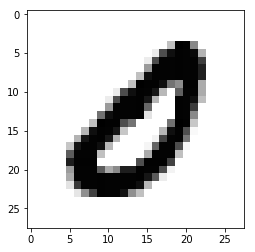

In [183]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

X, Y = digits[57435]
X = X * 255
plt.imshow(255 - X.reshape(28,28), cmap='gray')
print(Y)

In [184]:
image_str = ','.join(map(str, X.int().tolist()))
print(image_str)

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,240,253,252,246,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,252,252,253,252,252,193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,252,252,252,253,252,252,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,240,252,252,252,253,252,252,223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,253,240,140,114,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,240,253,252,233,71,0,159,252,252,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,178,252,252,253,233,74,0,0,253,252,239,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,252,252,252,253,151,0,0,0,253,252,195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,141,240,252,252,252,253,27,0,0,0,253,252,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,255,253,253,178,140,0,0,0,0,141,255,2

In [185]:
import json
import requests
service_url = service.scoring_uri
print(service_url)
r = requests.post(service_url, json={'image': image_str })
r.json()

http://13.83.148.236:80/score


{'time': 0.053836,
 'prediction': 0,
 'scores': [0.9993307590484619,
  1.2062910172971897e-06,
  0.0002674803836271167,
  8.174645336112007e-05,
  5.859145062458992e-07,
  0.00012238591443747282,
  6.691526505164802e-05,
  6.15604585618712e-05,
  6.217074405867606e-05,
  5.264257197268307e-06]}